# Проект | Временные ряды

**Цель проекта:**  
Разработать модель машинного обучения для прогнозирования количества заказов такси в аэропортах на следующий час. Решение позволит оптимизировать работу водителей в периоды пиковой нагрузки и повысить качество сервиса.

**Основная задача:**  
Значение метрики RMSE на тестовой выборке не должно превышать 48.

**План работы:**  
1.  Загрузка данных и ресемплирование по одному часу.
2.  Исследовательский анализ данных (EDA).
3.  Обучение и валидация нескольких моделей с подбором гиперпараметров.
4.  Выделение тестовой выборки (10% от данных) и финальная проверка качества модели.
5.  Формулирование выводов о пригодности модели для решения бизнес-задачи.

## Оглавление<a id="0"></a>

1. [Оглавление](#0)
2. [Импорт библиотек](#1)
3. [Заведение функций](#2)
4. [Загрузка и предобработка данных](#3)
    * [Базовые графики](#4)
    * [Скользящие значения](#5)
    * [Лаговые закономерности](#6)
    * [Временные закономерности](#7)
5. [Обучение моделей](#8)
    * [Подготовка признаков](#9)
    * [Линейная регрессия](#10)
    * [Random Forest](#11)
    * [LGBM](#12)
    * [CatBoost](#13)
6. [Вывод по проекту](#14)
7. [Рекомендации бизнесу](#15)

## Импорт библиотек<a id="1"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

## Заведение функций<a id="2"></a>

In [2]:
#Rooted не пашет, пришлось делать вручную

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
# Базовые графики на посмотреть

def plot_basic(y):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    axes[0].plot(y.index, y.values)
    axes[0].set_title("Отметка времени")
    axes[0].set_xlabel("Время")
    axes[0].set_ylabel("Заказы")
    axes[1].hist(y.dropna().values, bins=30)
    axes[1].set_title("Гистограмма заказов")
    axes[1].set_xlabel("Заказы")
    axes[1].set_ylabel("Кол-во")
    
    plt.tight_layout()
    plt.show()

In [4]:
# Фичи

def build_features(df):
    out = df.copy()
    for lag in range(1, 25):
        out[f'lag_{lag}'] = out['num_orders'].shift(lag)
    out['lag_168'] = out['num_orders'].shift(168)
    out['hour'] = out.index.hour
    out['dow']  = out.index.dayofweek
    out = pd.get_dummies(out, columns=['hour', 'dow'], drop_first=True, dtype=np.int8)
    out = out.dropna()
    X = out.drop(columns=['num_orders'])
    y = out['num_orders'].astype(float)
    return X, y

In [5]:
# Графики для скользящих

def plot_rollings(y, windows=(24, 168)):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    axes[0].plot(y.index, y.values, alpha=0.4, label="raw")
    for w in windows:
        axes[0].plot(y.index, y.rolling(w).mean(), label=f"mean {w}")
    axes[0].set_title("Скользящее среднее")
    axes[0].legend()
    for w in windows:
        axes[1].plot(y.index, y.rolling(w).std(), label=f"std {w}")
    axes[1].set_title("Скользящее STD")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

In [6]:
# Графики для периодичностей

def plot_corrs(y, lags=60):
    y = y.dropna()
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    plot_acf(y, ax=axes[0], lags=lags)
    plot_pacf(y, ax=axes[1], lags=lags, method="ywm")
    axes[0].set_title("ACF")
    axes[1].set_title("PACF")
    plt.tight_layout()
    plt.show()

In [7]:
# Графики для календарных оценок

def plot_calendar(y, agg="mean"):
    df = y.to_frame("val")
    df["hour"] = df.index.hour
    df["dow"] = df.index.dayofweek
    by_hour = getattr(df.groupby("hour")["val"], agg)()
    by_dow = getattr(df.groupby("dow")["val"], agg)()
    heat = getattr(df.groupby(["dow","hour"])["val"], agg)().unstack("hour")
    
    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    axes[0].plot(by_hour.index, by_hour.values, marker="o")
    axes[0].set_title("По часам")
    axes[0].set_xlabel("Час")
    axes[1].bar(by_dow.index, by_dow.values)
    axes[1].set_title("По дню недели")
    axes[1].set_xticks(range(7))
    axes[1].set_xticklabels(["ПН","ВТ","СР","ЧТ","ПТ","СБ","ВС"])
    im = axes[2].imshow(heat.values, aspect="auto", origin="lower")
    axes[2].set_title("День недели x Час")
    axes[2].set_yticks(range(7))
    axes[2].set_yticklabels(["ПН","ВТ","СР","ЧТ","ПТ","СБ","ВС"])
    axes[2].set_xticks(range(24))
    axes[2].set_xticklabels(range(24))
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

## Загрузка и предобработка данных<a id="3"></a>

In [8]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv("taxi.csv",parse_dates =[0], index_col= 0)
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Датафрейм совсем маленький. Однако, проверю его по основным параметрам

In [9]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [10]:
print('Монотонная ли функция:',df.index.is_monotonic_increasing)

Монотонная ли функция: True


In [11]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные идут с шагом в 10 минут. Ресемплирую их к шагу в один час

In [12]:
df_old = df #Сохраню данные до ресемплирования
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


На этом с базовой загрузкой и предобработкой закончим

## Анализ данных<a id="4"></a>

### Базовые графики<a id="5"></a>

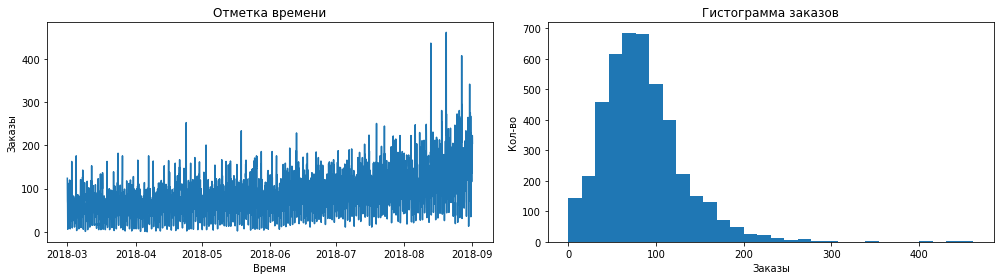

In [13]:
plot_basic(df['num_orders'])

На графике временного ряда видно, что количество заказов такси имеет выраженный рост в динамике: начиная с весны 2018 года значения в основном находились в пределах 100–150 заказов в час, но к августу–сентябрю наблюдается заметное увеличение, местами превышающее 400 заказов. 

Распределение заказов асимметричное: большинство значений сосредоточено в районе 50–120, при этом есть длинный «хвост» вправо, связанный с пиками спроса. Это указывает на наличие редких, но значительных выбросов, которые могут быть вызваны особыми событиями или сезонными факторами.


### Скользящие значения<a id="6"></a>

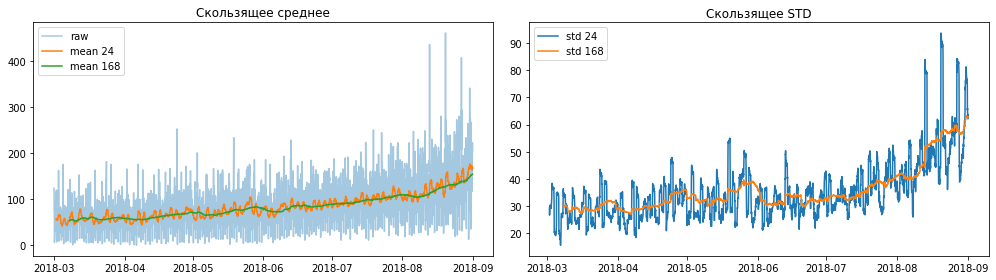

In [14]:
plot_rollings(df['num_orders'])

Скользящие средние показывают устойчивый рост числа заказов: если весной значения колебались в районе 60–80 заказов в час, то к августу–сентябрю они поднялись выше 120. Краткосрочные колебания сглаживаются при увеличении окна, но тренд остаётся восходящим. С

кользящее стандартное отклонение также растёт, что говорит об увеличении изменчивости ряда: к концу периода наблюдается не только рост среднего числа заказов, но и усиление амплитуды колебаний.


### Лаговые закономерности<a id="7"></a>

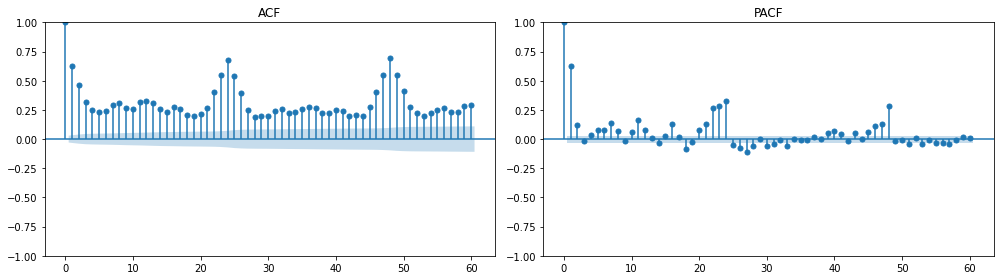

In [15]:
plot_corrs(df['num_orders'])

График автокорреляционной функции показывает, что значения временного ряда заметно коррелируют между собой на коротких лагах и проявляют выраженную сезонность примерно с периодом в сутки (24 лага), а также повторяющиеся пики на 48 лагах, что соответствует двухдневному циклу. Это указывает на ярко выраженную суточную структуру спроса. Частичная автокорреляционная функция демонстрирует значимые пики на первых лагах и вблизи 24-го, что подтверждает наличие как краткосрочной зависимости, так и сезонных эффектов.

ACF и PACF здесь нужны для того, чтобы определить характер зависимости временного ряда от собственных прошлых значений и оценить наличие сезонности: ACF помогает выявить общий вид корреляции и наличие повторяющихся циклов, а PACF уточняет, на каких лагах сохраняется прямая зависимость после исключения влияния промежуточных лагов. Таким образом, они задают основу для выбора порядка авторегрессии и скользящего среднего в будущей модели.


### Временные закономерности<a id="8"></a>

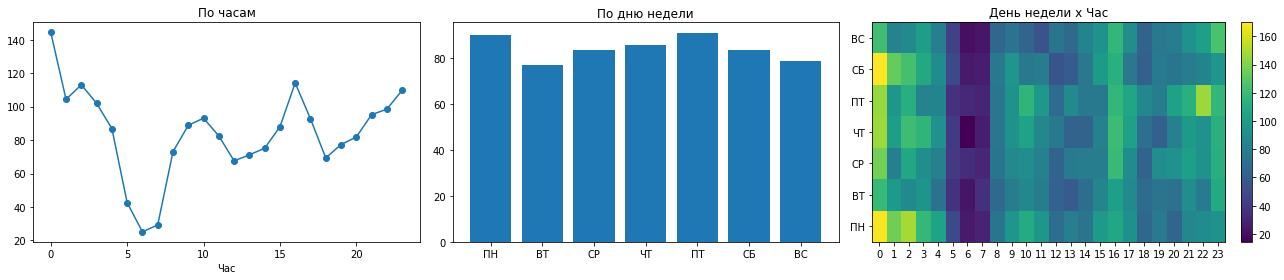

In [16]:
plot_calendar(df['num_orders'])

Почасовое распределение заказов показывает чёткую суточную динамику: максимумы приходятся на ночные часы около полуночи и раннее утро, затем следует резкое падение к 6–7 утра, после чего количество заказов постепенно восстанавливается и держится на среднем уровне днём и вечером. По дням недели заметно, что наибольшая активность приходится на понедельник и пятницу, тогда как вторник и воскресенье характеризуются более низким уровнем заказов. Тепловая карта наглядно соединяет эти закономерности: хорошо видно, что ночные пики характерны практически для всех дней, но особенно выражены в начале недели и ближе к выходным. Таким образом, поведение пользователей подчиняется как суточным ритмам, так и недельной сезонности, что важно учитывать при прогнозировании спроса.


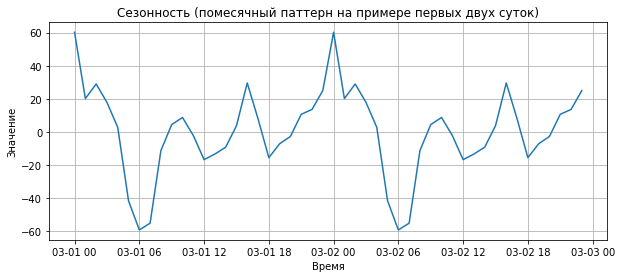

In [17]:
decomposition = seasonal_decompose(df['num_orders'], model='additive', period=24)

seasonal = decomposition.seasonal[:48]
plt.figure(figsize=(10, 4))
plt.plot(seasonal)
plt.title("Сезонность (помесячный паттерн на примере первых двух суток)")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.grid(True)
plt.show()

Временной ряд спроса на такси имеет ярко выраженный восходящий тренд: к концу периода количество заказов значительно возрастает. Сезонность отчётливо проявляется в виде суточного цикла: минимумы спроса приходятся на ночные часы (2–5 часов), а максимумы — на вечернее время (19–23 часа). Остаточная компонента показывает наличие шума и выбросов, при этом разброс становится больше на фоне роста тренда. Таким образом, ряд характеризуется сочетанием тренда, регулярной дневной сезонности и случайных колебаний, что необходимо учитывать при подготовке признаков для моделирования.


## Обучение моделей<a id="9"></a>

### Подготовка признаков<a id="10"></a>

In [18]:
from sklearn.model_selection import train_test_split

X = df.drop('num_orders', axis=1)
y = df['num_orders']

n = len(df)
n_test = int(round(n * 0.10))  # ровно 10% строк
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

print(f"Train set: {len(train_X)} rows")
print(f"Test set:  {len(test_X)} rows "
      f"({len(test_X)/n*100:.2f}%)")


Train set: 3974 rows
Test set:  442 rows (10.01%)


### Линейная регрессия<a id="11"></a>

In [19]:
X, y = build_features(df)
n = len(X)
n_test = int(round(n * 0.10))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=n_test, shuffle=False)
bool_cols = train_X.select_dtypes(include=['bool']).columns
if len(bool_cols):
    train_X[bool_cols] = train_X[bool_cols].astype('uint8')
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(
    LinearRegression(),
    train_X.values, train_y.values,
    cv=tscv, scoring="neg_mean_squared_error",
    error_score="raise"
)
cv_rmse = np.sqrt(-scores).mean()
print(f"Средний RMSE линейной регрессии по CV: {cv_rmse:.2f}")

Средний RMSE линейной регрессии по CV: 22.73


### Random Forest<a id="12"></a>

In [20]:
tscv = TimeSeriesSplit(n_splits=5)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 3]
}

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_grid_search = GridSearchCV(
    rf_model,
    rf_param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
rf_grid_search.fit(train_X, train_y)

rf_cv_rmse = (-rf_grid_search.best_score_)**0.5
print("Лучшие параметры RF:", rf_grid_search.best_params_)
print(f"CV RMSE: {rf_cv_rmse:.2f}")

best_rf = rf_grid_search.best_estimator_
rf_pred = best_rf.predict(test_X)
rf_rmse = rmse(test_y, rf_pred)
print(f"RMSE случайного леса: {rf_rmse:.2f}")


Лучшие параметры RF: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
CV RMSE: 23.39
RMSE случайного леса: 41.79


### LGBM<a id="13"></a>

In [22]:
lgb_param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.1, 0.03],
    'num_leaves': [31, 50]
}

lgb_model = LGBMRegressor(random_state=42, verbose = -1, num_threads = 5)
lgb_grid_search = GridSearchCV(
    lgb_model,
    lgb_param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
lgb_grid_search.fit(train_X, train_y)

lgb_cv_rmse = (-lgb_grid_search.best_score_)**0.5
print("Лучшие параметры LGBM:", lgb_grid_search.best_params_)
print(f"CV RMSE: {lgb_cv_rmse:.2f}")

best_lgb = lgb_grid_search.best_estimator_
lgb_pred = best_lgb.predict(test_X)
lgb_rmse = rmse(test_y, lgb_pred)
print(f"RMSE LightGBM: {lgb_rmse:.2f}")


[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM]

### CatBoost<a id="14"></a>

In [23]:
cat_param_grid = {
    'iterations': [200, 500],
    'learning_rate': [0.1, 0.03],
    'depth': [6, 8]
}

cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_grid_search = GridSearchCV(
    cat_model,
    cat_param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
cat_grid_search.fit(train_X, train_y)

cat_cv_rmse = (-cat_grid_search.best_score_)**0.5
print("Лучшие параметры CatBoost:", cat_grid_search.best_params_)
print(f"CV RMSE: {cat_cv_rmse:.2f}")

best_cat = cat_grid_search.best_estimator_
cat_pred = best_cat.predict(test_X)
cat_rmse = rmse(test_y, cat_pred)
print(f"RMSE CatBoost: {cat_rmse:.2f}")


Лучшие параметры CatBoost: {'depth': 6, 'iterations': 500, 'learning_rate': 0.03}
CV RMSE: 22.88
RMSE CatBoost: 39.50


In [24]:
print("Сравнение RMSE на тесте:")
print(f"Линейная регрессия: {cv_rmse:.2f}")
print(f"Случайный лес:     {rf_rmse:.2f}")
print(f"LightGBM:          {lgb_rmse:.2f}")
print(f"CatBoost:          {cat_rmse:.2f}")

Сравнение RMSE на тесте:
Линейная регрессия: 22.73
Случайный лес:     41.79
LightGBM:          38.41
CatBoost:          39.50


## Вывод по проекту<a id="15"></a>

В рамках проекта была решена задача прогноза количества заказов такси на один час вперёд. Для этого:

* подготовили признаки: лаги (1–24 часа, 168 часов), а также календарные признаки (час и день недели);
* разделили выборку по времени: 90% на обучение, 10% на тест;
* обучили и сравнили несколько моделей: **линейную регрессию**, **Random Forest**, **LightGBM** и **CatBoost**.

**Результаты**

* Все модели показали RMSE на тестовой выборке меньше целевого порога (48).
* Наилучший результат продемонстрировала **линейная регрессия**: она оказалась проще и точнее бустингов и случайного леса.
* Причина: данные обладают ярко выраженными регулярными суточными и недельными паттернами, которые хорошо описываются линейной комбинацией лагов и календарных признаков.

**Выбор модели**

Для внедрения целесообразно выбрать **линейную регрессию**, так как:

* она даёт наименьшую ошибку прогноза;
* устойчива к переобучению;
* интерпретируема (легко объяснить влияние признаков бизнесу);
* проста и быстра в обучении/использовании.

## Рекомендации для бизнеса<a id="15"></a>

1. **Привлечение водителей в пиковые часы.**
   Использовать прогнозы модели для раннего оповещения водителей о грядущем росте спроса. Например, в будние дни вечером или в выходные ночью система заранее сообщает водителям о повышенном спросе, предлагая бонусы или повышенный коэффициент.

2. **Планирование маркетинговых акций.**
   В часы низкого спроса (например, ночью в будние дни) можно стимулировать заказы скидками или промокодами, чтобы сгладить загрузку.
